## With SNR 
**We can measure SNR using tf signal power if we know it**  
$ \text{SNR} = \log_{10}\!\left(\dfrac{TP}{TP - RP}\right) $


In [3]:
import pickle
import numpy as np
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
from tensorflow.keras import layers, models, Input
from tensorflow.keras.callbacks import EarlyStopping
from fastapi import FastAPI

C:\Users\akila\anaconda3\envs\tf_env\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


TensorFlow version: 2.19.0


In [7]:
with open("RML2016.10a_dict.pkl", 'rb') as f:
    data_dict = pickle.load(f)

#Structure: key = (modulation_type, snr)
keys=list(data_dict.keys())
class_1=data_dict[keys[0]]#list of one class
print("Number of keys:", len(keys))
print("Example key:", keys[0])
print("Shape of one sample:", class_1[0].shape)#acces first element of first key in dictionary
print(f"Rows: I/Q Components \nColomns:Samples for {class_1[0].shape[1]} time instances")
print("Shape of sample on one scheme:", class_1.shape)
print("First Sample",class_1[0])
def sample_stats(sample):
    return {"Mean_I":np.mean(sample[0]),"Mean_Q":np.mean(sample[1]),"STD_I": np.std(sample[0]),"STD_Q":np.std(sample[1])}

for sample in class_1[:11]:
  print(sample_stats(sample))  

#mod shemes
mod_schemes=[]
snr_values=[]
for tup in keys:
    if tup[0] not in mod_schemes:
        mod_schemes.append(tup[0])
    if tup[1] not in snr_values:
        snr_values.append(tup[1])
print(mod_schemes)

print(f"Number of modulation schemes {len(mod_schemes)}.") 
temp=snr_values
temp.sort()
print(temp)
print(f"Number of SNR values {len(snr_values)}.")  

Number of keys: 220
Example key: ('QPSK', 2)
Shape of one sample: (2, 128)
Rows: I/Q Components 
Colomns:Samples for 128 time instances
Shape of sample on one scheme: (1000, 2, 128)
First Sample [[-1.0265000e-03  5.8502653e-03 -9.3906338e-04 -2.2335863e-03
  -1.3568916e-04 -6.8309228e-04  4.1412762e-03  1.2770405e-03
  -3.4695407e-03 -6.4070662e-04  1.9288055e-03 -3.1959298e-03
   1.9657889e-03  2.2193526e-03  2.2501240e-03  1.0834818e-03
  -3.2876425e-03  3.2260290e-03  1.8539119e-03  1.4974185e-03
  -4.7951085e-03 -5.2285631e-04  1.1597933e-04  5.3670054e-04
  -1.6577138e-03  3.5826277e-03 -2.8328735e-03  1.7530784e-03
  -2.4740885e-03 -1.5094796e-03  9.3733874e-04 -1.8275570e-03
  -2.8713259e-03 -1.5362875e-03 -3.7586095e-04  8.5423136e-04
  -1.8415806e-03 -2.6825715e-03 -1.2375436e-03 -3.1134628e-03
   4.5682848e-03 -1.5236636e-03  7.2360924e-03 -1.0099898e-03
  -3.1587915e-04 -5.8839722e-03  2.0147045e-03 -3.5786787e-03
   1.0269805e-03  7.5495308e-03  3.1257968e-03  1.8570216e-03

**There are 220 keys for various schemes and SNR values.**  
**Each key is a (MOD,SNR) tuple**  
**Each tuple maps in to 1000x2x128 array [  [ [128],[128] ],...1000]**  
**Row of each example represents I/Q components while column represents samples from 128 time instances**   
**Totally dataset has 11 schemes over 20 snr values**  
**220 keys mean 220x1000 examples**



## Develop a neural network to output modulation scheme for given I/Q Example & SNR

In [8]:
def normalize_iq(sample):
    mean = np.mean(sample, axis=1, keepdims=True)
    std = np.std(sample, axis=1, keepdims=True) + 1e-6 #all samples equal std=0
    return (sample - mean) / std
#The network may focus on power differences rather than the modulation pattern  if not normalized
"""" Implemented to robust scalar observed model accuracy dont improve  
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
""""
#create x,y
X=[]
Y=[]
SNR=[]
#Selected_mods=['BPSK', 'QPSK', 'QAM16', 'QAM64', 'GFSK', 'CPFSK']
Selected_mods=['QPSK', 'PAM4', 'AM-DSB', 'GFSK', 'QAM64', 'AM-SSB', '8PSK', 'QAM16', 'WBFM', 'CPFSK', 'BPSK']
for key in keys:
   #if key[0] in Selected_mods:
  if key[1]>0: #noise power<signal power
    clz=data_dict[key]
    for ex in clz:
        
        X.append(normalize_iq(ex))
        SNR.append((key[1]+20)/38)
        Y.append(Selected_mods.index(key[0]))
        
# Convert to numpy arrays for tensorflow
X = np.array(X)    
SNR = np.array(SNR) 
Y = np.array(Y)     
SNR = SNR.reshape(-1, 1)  #99000 rows      
print("IQ shape:", X.shape)
print("SNR shape:", SNR.shape)
print("Labels shape:", Y.shape)    



IQ shape: (99000, 2, 128)
SNR shape: (99000, 1)
Labels shape: (99000,)


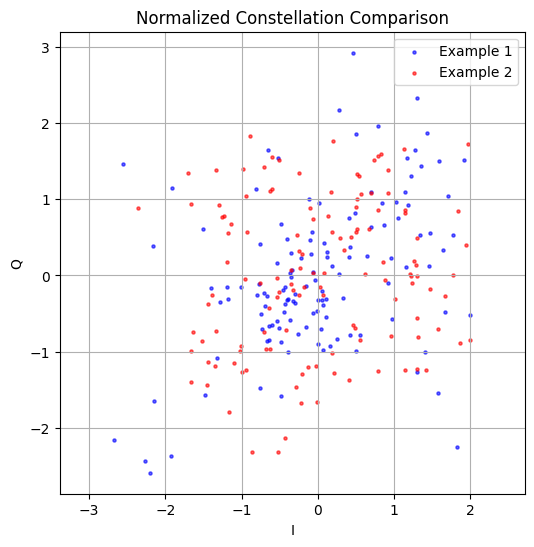

Max difference between example 1 and example 2 is 3.272561550140381


In [9]:
import matplotlib.pyplot as plt
I1, Q1 = X[0][0], X[0][1]
I2, Q2 = X[1][0], X[1][1]

plt.figure(figsize=(6,6))

# Plot Example 1 in blue
plt.scatter(I1, Q1, s=5, color='blue', alpha=0.6, label="Example 1")#S MEANS SIZE

# Plot Example 2 in red
plt.scatter(I2, Q2, s=5, color='red', alpha=0.6, label="Example 2")

plt.title("Normalized Constellation Comparison")
plt.xlabel("I")
plt.ylabel("Q")
plt.legend()
plt.grid(True)
plt.axis("equal")  # keep scale same on both axes
plt.show()
print(f"Max difference between example 1 and example 2 is {np.max(X[0]-X[1])}")

## Now split the data set to have all snr values equally distributed

In [10]:
X_train, X_val, X_test = [], [], []
SNR_train, SNR_val, SNR_test = [], [], []
Y_train, Y_val, Y_test = [], [], []

i = 0
total_samples = len(X)

while i < total_samples:
    # take 1000 samples of the same SNR 
    batch_size = 1000
    
    # train: first 750
    X_train.extend(X[i:i+750])
    SNR_train.extend(SNR[i:i+750])
    Y_train.extend(Y[i:i+750])
    
    # val: next 125
    X_val.extend(X[i+750:i+875])
    SNR_val.extend(SNR[i+750:i+875])
    Y_val.extend(Y[i+750:i+875])
    
    # test: last 125
    X_test.extend(X[i+875:i+1000])
    SNR_test.extend(SNR[i+875:i+1000])
    Y_test.extend(Y[i+875:i+1000])
    
    i += batch_size  # move to next SNR batch

# convert to numpy arrays
X_train = np.array(X_train)
SNR_train = np.array(SNR_train)
Y_train = np.array(Y_train)

X_val = np.array(X_val)
SNR_val = np.array(SNR_val)
Y_val = np.array(Y_val)

X_test = np.array(X_test)
SNR_test = np.array(SNR_test)
Y_test = np.array(Y_test)

print("Train shapes:", X_train.shape, SNR_train.shape, Y_train.shape)
print("Val shapes:", X_val.shape, SNR_val.shape, Y_val.shape)
print("Test shapes:", X_test.shape, SNR_test.shape, Y_test.shape)


Train shapes: (74250, 2, 128) (74250, 1) (74250,)
Val shapes: (12375, 2, 128) (12375, 1) (12375,)
Test shapes: (12375, 2, 128) (12375, 1) (12375,)


In [6]:
num_classes=len(Selected_mods)
iq_input = Input(shape=(2,128), name='IQ_Input')
x = layers.Permute((2,1))(iq_input)  # Conv1d operete on colouns filters get large no improvement 
#32 filters used
x = layers.Conv1D(32, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)#128x32
x = layers.Conv1D(32, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = layers.SpatialDropout1D(0.2)(x)  # regularize convolutional layers
x = layers.Flatten()(x)#for dense layer (bact size,128x32)
x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = layers.Dropout(0.4)(x)  #dropout 40% off randomly

# SNR input
snr_input = Input(shape=(1,), name='SNR_Input')
y = layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(snr_input)

# Combine IQ and SNR features
combined = layers.concatenate([x, y])
z = layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(combined)
z = layers.Dropout(0.4)(z)
output = layers.Dense(num_classes, activation='softmax')(z)

# Create model
model = models.Model(inputs=[iq_input, snr_input], outputs=output)

# Compile
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  #Loss=−log(ptrue_class​)
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ IQ_Input            │ (None, 2, 128)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute (Permute)   │ (None, 128, 2)    │          0 │ IQ_Input[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 128, 32)   │        224 │ permute[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 128, 32)   │      3,104 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, 128, 32)   │          0 │ conv1d_1[0][0]    │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 4096)      │          0 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    524,416 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ SNR_Input           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 8)         │         16 │ SNR_Input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 136)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,768 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 11)        │        715 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 537,243 (2.05 MB)

 Trainable params: 537,243 (2.05 MB)

 Non-trainable params: 0 (0.00 B)

              IQ Input (2,128)
                  |
            Permute 
                  |
            Conv1D(32, kernel=3) 
                  |
            Conv1D(32, kernel=3)
                  |
                Flatten 
                  |
           Dense(128, activation='relu')
                  |
                  |                    SNR Input (1,)
                  |                          |
                  |                     Dense(8, activation='relu')
                  |                          |
                  +----------Concatenate-----------+
                              |
                        Dense(64, activation='relu')
                              |
                     Dense(num_classes=11, activation='softmax')
                              |
                         Output (11,)


In [7]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    [X_train, SNR_train], Y_train,
    validation_data=([X_val, SNR_val], Y_val),
    epochs=50,
    batch_size=128,
    callbacks=[early_stop],
    shuffle=True
)


Epoch 1/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.2450 - loss: 1.9500 - val_accuracy: 0.4532 - val_loss: 1.2889
Epoch 2/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.4222 - loss: 1.3446 - val_accuracy: 0.4968 - val_loss: 1.0995
Epoch 3/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.4769 - loss: 1.1803 - val_accuracy: 0.5086 - val_loss: 1.0600
Epoch 4/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.4913 - loss: 1.1312 - val_accuracy: 0.5162 - val_loss: 1.0436
Epoch 5/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.5070 - loss: 1.1054 - val_accuracy: 0.5214 - val_loss: 1.0413
Epoch 6/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5059 - loss: 1.0923 - val_accuracy: 0.5222 - val_loss: 1.0233
Epoch 7/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5121 - loss: 1.0837 - val_accuracy: 0.5369 - val_loss: 1.0262
Epoch 8/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.5190 - loss: 1.0706 - val_ac

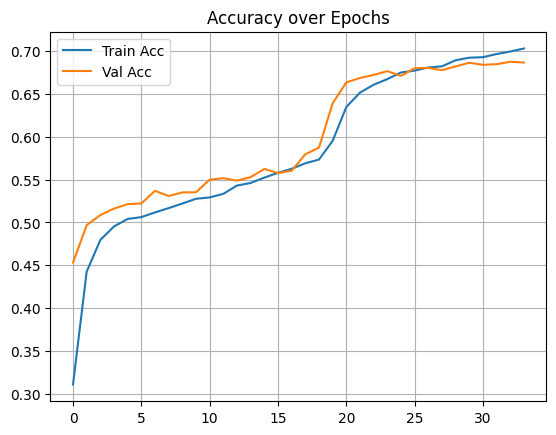

In [8]:


import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy over Epochs")
plt.legend()
plt.grid()
plt.show()




## 69% accuracy is enough for snr values>0 and 11 classes here is slight overfiting attained max is about 80%

In [9]:
test_loss, test_acc = model.evaluate(
    {'IQ_Input': X_test, 'SNR_Input': SNR_test},
    Y_test,
    batch_size=128
)

print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6758 - loss: 0.7912   
Test Accuracy: 68.30%
Test Loss: 0.7980


In [10]:
#save the model
model.save("modulation_model.keras")


In [15]:
model = tf.keras.models.load_model("modulation_model.keras")
Y_pred=model.predict({"IQ_Input":X_test,"SNR_Input":SNR_test})
print(Y_pred[0])
Y_pred_classes = np.argmax(Y_pred, axis=1)#max index
print(Y_pred_classes[0])

387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
[2.1391898e-01 6.8244845e-09 3.9914690e-12 4.6823774e-07 2.6498470e-01
 3.0696051e-10 2.3573908e-01 2.8520080e-01 9.5106685e-08 1.5581616e-04
 3.0010700e-08]
7


In [16]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report
cm = confusion_matrix(Y_test, Y_pred_classes)
print("Confusion Matrix:\n", cm)#true class x predicted class

Confusion Matrix:
 [[ 451    5    3    3    1    5  593   50    0   11    3]
 [   1 1057    3    2    0    5    2    9    4    0   42]
 [   0    0  387    0    2  693    1    2   39    0    1]
 [   1   14    2 1058    4    1    1    9   26    5    4]
 [  10    6    1    1   17    4  140  941    1    3    1]
 [   1    0  208    0    1  893    1    2   19    0    0]
 [  34    2    3    0    6    2 1022   52    0    4    0]
 [   6    4    0    2   14    4  130  962    0    2    1]
 [   1    6  216   22    1  390    3    4  481    1    0]
 [   1    1    0    3    2    0    6   13    0 1099    0]
 [   4   80    2    0    1    3    0    7    2    1 1025]]


In [18]:
Selected_mods=['QPSK', 'PAM4', 'AM-DSB', 'GFSK', 'QAM64', 'AM-SSB', '8PSK', 'QAM16', 'WBFM', 'CPFSK', 'BPSK']
print(Selected_mods)

['QPSK', 'PAM4', 'AM-DSB', 'GFSK', 'QAM64', 'AM-SSB', '8PSK', 'QAM16', 'WBFM', 'CPFSK', 'BPSK']


**True class 0 has predicted wrong way more predicted as class 6**  

**True class 2 has wrong 5**  

**True class 4 wrong 7**  

**PAM4,GFSK,AM-SSB,8PSK,QAM16,CPFSK,,BPSK has predicted correctly**

**Some modulation schemes have very similar signal characteristics, especially under noisy conditions. eg-AM_SDB,AM_SSB and QPSK,8_PSK**  


**Classes that have distinct features tend to be classified correctly more easily.**

In [17]:
f1 = f1_score(Y_test, Y_pred_classes, average='weighted')
print(f"F1 Score (weighted): {f1:.4f}")

F1 Score (weighted): 0.6526


## API

app = FastAPI() #full duplex,automatic ui,high performance
model = tf.keras.models.load_model("modulation_model.keras")

@app.post("/predict")#CREATE POST ENDPOINT
#fastapi automatically calls this function request hits the endpoint /predict.
def predict_modulation(data: list,SNR: int):
    # data is your IQ sample array
    sample = np.array(data)
    size=sample.shape
    if size!=(2,128):
        if size==(128,2):
            sample=sample.T
        else:
            raise HTTPException(
                status_code=400,
                detail=f"Invalid input shape {size}, expected (2,128) or (128,2)"
            )
            
    pred = model.predict({"iq_input": sample, "snr_input": np.array([[SNR]])})
    modulation_class = np.argmax(pred)
    confidence = np.max(pred)
    return {"modulation": int(modulation_class), "confidence": float(confidence)}


iq_sample = np.random.rand(2, 128).tolist()

# SNR value
snr_value = [10]

# Combine IQ sample and SNR
data = iq_sample + [snr_value]

arr = np.array(data)

    # Last row is SNR
SNR = arr[-1][0]
    # First rows are IQ data
sample = arr[:-1]

size = sample.shape
if size != (2, 128):
        if size == (128, 2):
            sample = sample.T
        else:
            raise HTTPException(
                status_code=400,
                detail=f"Invalid input shape {size}, expected (2,128) or (128,2)"
            )

pred = model.predict({"iq_input": [sample], "snr_input": np.array([[SNR]])})
